In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np                                                                                          
import matplotlib.pyplot as plt                                 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder   
import torchvision                
import torchvision.transforms as transforms      
from torch.utils.data import DataLoader          
from torch.utils.data import SubsetRandomSampler 
import torch.utils.data as data   
from torchsummary import summary
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from time import time
import os
import copy

import sys
sys.path.append('/content/gdrive/My Drive/ECE324 project/Additional files')
sys.path.append('/content/gdrive/My Drive/ECE324 project/data')

from Data_Loader import *

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
'''
my_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.66445047,0.55465436,0.447036], std = [0.321551,0.33547384,0.3524585])
  ])

dataset =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/data_overfit', transform=my_transform)


#train_loader = DataLoader(dataset, batch_size=45,shuffle= True)
dataset.classes'''


"\nmy_transform = transforms.Compose([\n  transforms.ToTensor(),\n  transforms.ToPILImage(),\n  transforms.Resize((224,224)),\n  transforms.ToTensor(),\n  transforms.Normalize(mean = [0.66445047,0.55465436,0.447036], std = [0.321551,0.33547384,0.3524585])\n  ])\n\ndataset =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/data_overfit', transform=my_transform)\n\n\n#train_loader = DataLoader(dataset, batch_size=45,shuffle= True)\ndataset.classes"

In [ ]:
my_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.ToPILImage(),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.66445047,0.55465436,0.447036], std = [0.321551,0.33547384,0.3524585])
  ])

dataset_clean =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/Clean Data', transform=my_transform)

print(len(dataset_clean)) # 14999
train_data, valid_data, test_data = torch.utils.data.random_split(dataset_clean, [9600,2400,2999], generator=torch.Generator().manual_seed(0))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)                  
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

test_white =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/test_white_bg', transform=my_transform)
test_varied =  torchvision.datasets.ImageFolder(root='/content/gdrive/MyDrive/ECE324 project/test_varied_bg', transform=my_transform)

test_white_loader = DataLoader(test_white, batch_size=8)
test_varied_loader = DataLoader(test_varied, batch_size=8)
print(len(test_white))
print(len(test_varied))


14999
75
75


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

cuda
Tue Nov 24 02:22:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
from torchvision import models
from torch import nn
vgg = models.vgg16_bn(pretrained=True)
for param in vgg.features.parameters():
    param.requires_grad = False

#vgg.features[43] = nn.Sequential(vgg.features[43],nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#                nn.ReLU(inplace=True))

#vgg.features[43] = nn.Sequential(vgg.features[43],nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#                nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),nn.Dropout(p=0.5))

In [ ]:
class MyVgg(nn.Module):
    def __init__(self,originalmodel):
        super(MyVgg,self).__init__()
        vgg = originalmodel
        # Here you get the bottleneck/feature extractor
        self.vgg_feature_extractor = nn.Sequential(*list(vgg.children())[:-1])

        self.classifier1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 3),
            nn.Sigmoid()
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 5),
            nn.Sigmoid()
                            )

    # Set your own forward pass
    def forward(self, img, extra_info=None):

        x = self.vgg_feature_extractor(img)
        x = x.view(x.size(0), -1)
        x1 = self.classifier1(x)
        x2 = self.classifier2(x)

        return x1, x2

In [ ]:
#MODEL ARGUMENTS
lr = 0.03
epochs = 20
eval_every = 5
model = MyVgg(vgg)
model.to(device)
my_optim = torch.optim.SGD(model.parameters(), lr=lr)
decayRate = 0.96
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=my_optim, gamma=decayRate)
loss_fnc= torch.nn.CrossEntropyLoss() 
loss_fnc.to(device)
batch_size = 64



#OUTPUT DATA ARGUMENTS
seed = 1
torch.manual_seed(seed)
save= True
confusion=True
plot = True
statistics = True

In [ ]:
def relabel_state(argument):
    switcher = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 1,
        6: 1,
        7: 1,
        8: 1,
        9: 1,
        10:2,
        11:2,
        12:2,
        13:2,
        14:2}
    return switcher[argument.item()]

def relabel_type(argument):
    switcher = {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 0,
        6: 1,
        7: 2,
        8: 3,
        9: 4,
        10:0,
        11:1,
        12:2,
        13:3,
        14:4}
    return switcher[argument.item()]

In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=1, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
train_loss_list = []
train_acc_list = []
train_loss_list_state = []
train_acc_list_state = []
train_loss_list_type = []
train_acc_list_type = []

valid_loss_list = []
valid_acc_list = []
valid_loss_list_state = []
valid_acc_list_state = []
valid_loss_list_type = []
valid_acc_list_type = []

epoch_list = []         #Epoch number
start = time()

for e in range(epochs):
    model.train()
    print("Time:    ", time() - start)
    running_loss = []
    running_accuracy = []
    running_loss_state = []
    running_accuracy_state = []
    running_loss_type = []
    running_accuracy_type = []

    running_valid_loss = []
    running_valid_accuracy = []
    running_valid_loss_state = []
    running_valid_accuracy_state = []
    running_valid_loss_type = []
    running_valid_accuracy_type = []

  #               LOOKING AT TRAINING DATA

    for i, data in enumerate(train_loader):

            #get batch of data
        inputs, label = data[0].to(device), data[1].to(device)
    
        label_state = torch.zeros(len(label)).to(device)
        label_type = torch.zeros(len(label)).to(device)

        for k in range(len(label)):
          label_state[k] = relabel_state(label[k])
          label_type[k] = relabel_type(label[k])

        
        # Setting gradients to zero and running model on batch
        my_optim.zero_grad()
        predictions_state, predictions_type = model(inputs)

        # Computing loss based on Cross Entropy
        batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
        batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

        # Combining losses and calculating gradients
        Overall_loss = batch_loss_state + batch_loss_type
        Overall_loss.backward()
        my_optim.step()
        # Evaluating Training Acc
        _, predicted_state = torch.max(predictions_state.data, 1)
        _,predicted_type = torch.max(predictions_type.data, 1)

        trainAcc_state = (label_state == predicted_state).sum().item() / 64
        trainAcc_type = (label_type == predicted_type).sum().item() / 64

        if i % eval_every == 0:
           print("epoch: {} {} |||   loss type:   {}  trainAcc type:   {} |||  loss state {}  trainAcc state:  {}  ".format(e+1,i, batch_loss_type, trainAcc_type, batch_loss_state, trainAcc_state))

        running_loss.append(Overall_loss.item())
        running_accuracy.append((trainAcc_state+trainAcc_type)/2)
        running_loss_state.append(batch_loss_state.item())
        running_accuracy_state.append(trainAcc_state)
        running_loss_type.append(batch_loss_type.item())
        running_accuracy_type.append(trainAcc_type)

        del Overall_loss
        del batch_loss_state
        del batch_loss_type
        del label_state
        del label_type
        del predictions_state
        del predictions_type
  
    for j, data in enumerate(valid_loader):
        model.eval()
            #get batch of data
        inputs, label = data[0].to(device), data[1].to(device)
    
        vlabel_state = torch.zeros(len(label)).to(device)
        vlabel_type = torch.zeros(len(label)).to(device)

        for k in range(len(label)):
          vlabel_state[k] = relabel_state(label[k])
          vlabel_type[k] = relabel_type(label[k]) 

          #run model on validation batch
        predictions_state_v, predictions_type_v = model(inputs)

            #compute loss
        batch_valid_loss_state = loss_fnc(input=predictions_state_v.squeeze(), target=vlabel_state.long())
        batch_valid_loss_type = loss_fnc(input=predictions_type_v.squeeze(), target=vlabel_type.long())

        Overall_loss_v = batch_valid_loss_state.float() + batch_valid_loss_type.float()

            #evaluate
        _, predicted_state_v = torch.max(predictions_state_v.data, 1)
        _,predicted_type_v = torch.max(predictions_type_v.data, 1)

        validAcc_state = (vlabel_state == predicted_state_v).sum().item() / 64
        validAcc_type = (vlabel_type == predicted_type_v).sum().item() / 64

        if j % eval_every == 0:
             print("epoch: {} |||   vloss type:   {}  validAcc type:   {} |||  vloss state {}  validAcc state:  {}  ".format(e+1, batch_valid_loss_type, validAcc_type, batch_valid_loss_state,validAcc_state))
        
        running_valid_loss.append(Overall_loss_v.item())
        running_valid_accuracy.append((validAcc_state+validAcc_type)/2)
        running_valid_loss_state.append(batch_valid_loss_state.item())
        running_valid_accuracy_state.append(validAcc_state)
        running_valid_loss_type.append(batch_valid_loss_type.item())
        running_valid_accuracy_type.append(validAcc_type) 

        del Overall_loss_v
        del batch_valid_loss_state
        del batch_valid_loss_type
        del vlabel_state
        del vlabel_type
        del predictions_state_v
        del predictions_type_v

    #Overall accuracy
    trainacc_ = sum(running_accuracy) / float(len(running_accuracy))
    train_acc_list.append(trainacc_)
    #state accuracy
    trainacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))
    train_acc_list_state.append(trainacc_state_)
    #type accuracy
    trainAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))
    train_acc_list_type.append(trainAcc_type_) 

    #             lists for TRAINING losses
    #Overall Loss
    loss_ = sum(running_loss) / float(len(running_loss))
    train_loss_list.append(loss_)
    #State Loss
    loss_state_ = sum(running_loss_state) / float(len(running_loss_state))
    train_loss_list_state.append(loss_state_)
    #Type Loss
    loss_type_ = sum(running_loss_type) / float(len(running_loss_type))
    train_loss_list_type.append(loss_type_) 

    #------------------------------------------------------------------------------------
    #             lists for VALIDATION accuracy
    #Overall accuracy
    validacc_ = sum(running_valid_accuracy) / float(len(running_valid_accuracy))
    valid_acc_list.append(validacc_)
    #state accuracy
    validacc_state_ = sum(running_valid_accuracy_state) / float(len(running_valid_accuracy_state))
    valid_acc_list_state.append(validacc_state_)
    #type accuracy
    validAcc_type_ = sum(running_valid_accuracy_type) / float(len(running_valid_accuracy_type))
    valid_acc_list_type.append(validAcc_type_)

    #             lists for VALIDATION losses
    #Overall Loss
    valid_loss_ = sum(running_valid_loss) / float(len(running_valid_loss))
    valid_loss_list.append(valid_loss_)
    #State Loss
    valid_loss_state_ = sum(running_valid_loss_state) / float(len(running_valid_loss_state))
    valid_loss_list_state.append(valid_loss_state_)
    #Type Loss
    valid_loss_type_ = sum(running_valid_loss_type) / float(len(running_valid_loss_type))
    valid_loss_list_type.append(valid_loss_type_)

    a=EarlyStopping(valid_loss_, model)

    if a.early_stop == True:
        print("Early stopping")
        break


Time:     0.0010533332824707031
epoch: 1 0 |||   loss type:   1.6074334383010864  trainAcc type:   0.265625 |||  loss state 1.0987586975097656  trainAcc state:  0.3125  
epoch: 1 5 |||   loss type:   1.5640426874160767  trainAcc type:   0.625 |||  loss state 1.0768061876296997  trainAcc state:  0.625  
epoch: 1 10 |||   loss type:   1.5648763179779053  trainAcc type:   0.4375 |||  loss state 1.0674899816513062  trainAcc state:  0.75  
epoch: 1 15 |||   loss type:   1.5416715145111084  trainAcc type:   0.625 |||  loss state 1.0476917028427124  trainAcc state:  0.796875  
epoch: 1 20 |||   loss type:   1.4996317625045776  trainAcc type:   0.84375 |||  loss state 1.017125129699707  trainAcc state:  0.765625  
epoch: 1 25 |||   loss type:   1.4263581037521362  trainAcc type:   0.921875 |||  loss state 0.9958961606025696  trainAcc state:  0.828125  
epoch: 1 30 |||   loss type:   1.4632457494735718  trainAcc type:   0.796875 |||  loss state 0.9920494556427002  trainAcc state:  0.796875  
ep

In [ ]:
print("Max train Acc: ", max(train_acc_list))
print("Max valid Acc: ", max(valid_acc_list))

Max train Acc:  0.9978645833333334
Max valid Acc:  0.9784128289473685


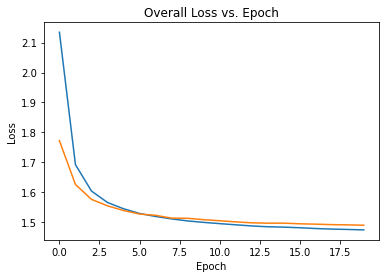

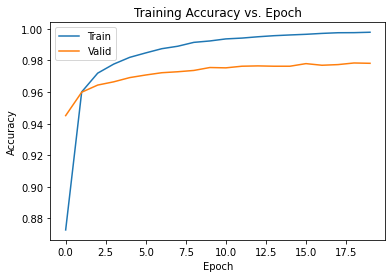

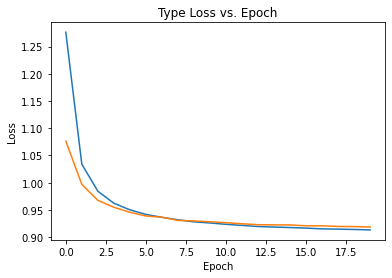

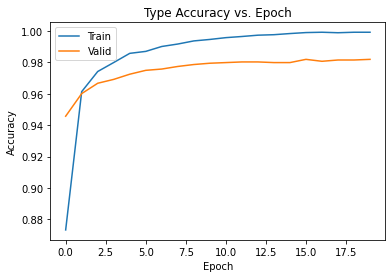

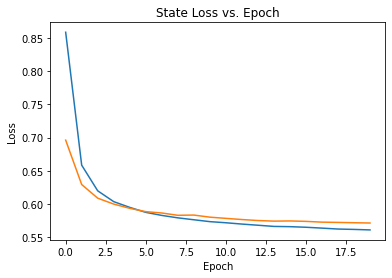

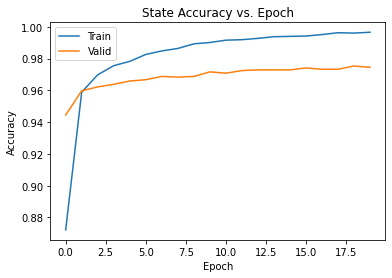

<Figure size 432x288 with 0 Axes>

In [ ]:
if plot == True:
        epoch_num = range(20)
        #Plot overall loss vs epoch
        plt.plot(epoch_num, train_loss_list, label='Train')
        plt.plot(epoch_num, valid_loss_list, label='Valid')
        plt.title('Overall Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('overall_loss')

        #Plot overall Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list, label='Train')
        plt.plot(epoch_num, valid_acc_list, label='Valid')
        plt.title('Training Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('train_acc')

                #Plot TYPE loss vs epoch
        plt.plot(epoch_num, train_loss_list_type, label='Train')
        plt.plot(epoch_num, valid_loss_list_type, label='Valid')
        plt.title('Type Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('type_loss')

                #Plot TYPE Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list_type, label='Train')
        plt.plot(epoch_num, valid_acc_list_type, label='Valid')
        plt.title('Type Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('type_acc')

                #Plot STATE loss vs epoch
        plt.plot(epoch_num, train_loss_list_state, label='Train')
        plt.plot(epoch_num, valid_loss_list_state, label='Valid')
        plt.title('State Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        plt.savefig('state_loss')

                #Plot STATE Accuracy vs epoch
        plt.plot(epoch_num, train_acc_list_state, label='Train')
        plt.plot(epoch_num, valid_acc_list_state, label='Valid')
        plt.title('State Accuracy vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        plt.savefig('state_acc')


In [ ]:
running_loss = []
running_accuracy = []
running_loss_state = []
running_accuracy_state = []
running_loss_type = []
running_accuracy_type = []
for i, data in enumerate(test_white_loader):
        #get batch of data
    inputs, label = data[0].to(device), data[1].to(device)

    label_state = torch.zeros(len(label)).to(device)
    label_type = torch.zeros(len(label)).to(device)
    for k in range(len(label)):
        label_state[k] = relabel_state(label[k])
        label_type[k] = relabel_type(label[k]) 

    #run model on validation batch
    predictions_state, predictions_type = model(inputs)

        #compute loss
    batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
    batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

    Overall_loss = batch_loss_state + batch_loss_type
        #evaluate
    _, predicted_state = torch.max(predictions_state.data, 1)
    _,predicted_type = torch.max(predictions_type.data, 1)

    Acc_state = (label_state == predicted_state).sum().item() / 8
    Acc_type = (label_type == predicted_type).sum().item() / 8
    running_loss.append(Overall_loss.item())
    running_accuracy.append((Acc_state+Acc_type)/2)

    running_loss_state.append(batch_loss_state.item())
    running_accuracy_state.append(Acc_state)
    running_loss_type.append(batch_loss_type.item())
    running_accuracy_type.append(Acc_type) 
    
#Overall accuracy
whiteacc_ = sum(running_accuracy) / float(len(running_accuracy))
#state accuracy
whiteacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))

#type accuracy
whiteAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))

#             lists for VALIDATION losses
#Overall Loss
white_loss_ = sum(running_loss) / float(len(running_loss))

#State Loss
white_loss_state_ = sum(running_loss_state) / float(len(running_loss_state))

#Type Loss
white_loss_type_ = sum(running_loss_type) / float(len(running_loss_type))

print("White background accuracy:")
print(whiteacc_)
print("White background loss:")
print(white_loss_)



running_loss = []
running_accuracy = []
running_loss_state = []
running_accuracy_state = []
running_loss_type = []
running_accuracy_type = []
for i, data in enumerate(test_varied_loader):
        #get batch of data
    inputs, label = data[0].to(device), data[1].to(device)

    label_state = torch.zeros(len(label)).to(device)
    label_type = torch.zeros(len(label)).to(device)
    for k in range(len(label)):
        label_state[k] = relabel_state(label[k])
        label_type[k] = relabel_type(label[k]) 

    #run model on validation batch
    predictions_state, predictions_type = model(inputs)

        #compute loss
    batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
    batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

    Overall_loss = batch_loss_state + batch_loss_type
        #evaluate
    _, predicted_state = torch.max(predictions_state.data, 1)
    _,predicted_type = torch.max(predictions_type.data, 1)

    Acc_state = (label_state == predicted_state).sum().item() / 8
    Acc_type = (label_type == predicted_type).sum().item() / 8
    running_loss.append(Overall_loss.item())
    running_accuracy.append((Acc_state+Acc_type)/2)

    running_loss_state.append(batch_loss_state.item())
    running_accuracy_state.append(Acc_state)
    running_loss_type.append(batch_loss_type.item())
    running_accuracy_type.append(Acc_type) 
    
#Overall accuracy
variedacc_ = sum(running_accuracy) / float(len(running_accuracy))
#state accuracy
variedacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))

#type accuracy
variedAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))

#             lists for VALIDATION losses
#Overall Loss
varied_loss_ = sum(running_loss) / float(len(running_loss))

#State Loss
varied_loss_state_ = sum(running_loss_state) / float(len(running_loss_state))

#Type Loss
varied_loss_type_ = sum(running_loss_type) / float(len(running_loss_type))

print("Varied background accuracy:")
print(variedacc_)
print("Varied background loss:")
print(varied_loss_)



running_loss = []
running_accuracy = []
running_loss_state = []
running_accuracy_state = []
running_loss_type = []
running_accuracy_type = []
for i, data in enumerate(test_loader):
        #get batch of data
    inputs, label = data[0].to(device), data[1].to(device)

    label_state = torch.zeros(len(label)).to(device)
    label_type = torch.zeros(len(label)).to(device)
    for k in range(len(label)):
        label_state[k] = relabel_state(label[k])
        label_type[k] = relabel_type(label[k]) 

    #run model on validation batch
    predictions_state, predictions_type = model(inputs)

        #compute loss
    batch_loss_state = loss_fnc(input=predictions_state.squeeze(), target=label_state.long())
    batch_loss_type = loss_fnc(input=predictions_type.squeeze(), target=label_type.long())

    Overall_loss = batch_loss_state + batch_loss_type
        #evaluate
    _, predicted_state = torch.max(predictions_state.data, 1)
    _,predicted_type = torch.max(predictions_type.data, 1)

    Acc_state = (label_state == predicted_state).sum().item() / 64
    Acc_type = (label_type == predicted_type).sum().item() / 64
    running_loss.append(Overall_loss.item())
    running_accuracy.append((Acc_state+Acc_type)/2)

    running_loss_state.append(batch_loss_state.item())
    running_accuracy_state.append(Acc_state)
    running_loss_type.append(batch_loss_type.item())
    running_accuracy_type.append(Acc_type) 
    
#Overall accuracy
testacc_ = sum(running_accuracy) / float(len(running_accuracy))
#state accuracy
testacc_state_ = sum(running_accuracy_state) / float(len(running_accuracy_state))

#type accuracy
testAcc_type_ = sum(running_accuracy_type) / float(len(running_accuracy_type))

#             lists for VALIDATION losses
#Overall Loss
test_loss_ = sum(running_loss) / float(len(running_loss))

#State Loss
test_loss_state_ = sum(running_loss_state) / float(len(running_loss_state))

#Type Loss
test_loss_type_ = sum(running_loss_type) / float(len(running_loss_type))

print("Test set accuracy:")
print(testacc_)
print("Test set loss:")
print(test_loss_)

White background accuracy:
0.93125
White background loss:
1.4906188011169434
Varied background accuracy:
0.925
Varied background loss:
1.5041053771972657
Test set accuracy:
0.9853723404255319
Test set loss:
1.4942273763900107


In [ ]:
def recombine_prediction(argument1,argument2):
    switcher = {
         str([0,0]): 0,
         str([0,1]): 1,
         str([0,2]): 2,
         str([0,3]): 3,
         str([0,4]): 4,
         str([1,0]): 5,
         str([1,1]): 6,
         str([1,2]): 7,
         str([1,3]): 8,
         str([1,4]): 9,
         str([2,0]):10,
         str([2,1]):11,
         str([2,2]):12,
         str([2,3]):13,
         str([2,4]):14}
    return switcher[str([argument1.item(),argument2.item()])]

In [ ]:
 from sklearn.metrics import confusion_matrix
# Initialize the prediction and label lists(tensors)
predlist_state=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_state=torch.zeros(0,dtype=torch.long, device='cpu')
predlist_type=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist_type=torch.zeros(0,dtype=torch.long, device='cpu')
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, label = data[0].to(device), data[1].to(device)
        vlabel_state = torch.zeros(len(label)).to(device)
        vlabel_type = torch.zeros(len(label)).to(device)
        for k in range(len(label)):
            vlabel_state[k] = relabel_state(label[k])
            vlabel_type[k] = relabel_type(label[k])
            
        
        predictions_state_v, predictions_type_v = model(inputs)
        _, predicted_state_v = torch.max(predictions_state_v.data, 1)
        _,predicted_type_v = torch.max(predictions_type_v.data, 1)

        # Append batch prediction results
        predlist_state=torch.cat([predlist_state,predicted_state_v.view(-1).cpu()])
        lbllist_state=torch.cat([lbllist_state,vlabel_state.view(-1).cpu()])
        predlist_type=torch.cat([predlist_type,predicted_type_v.view(-1).cpu()])
        lbllist_type=torch.cat([lbllist_type,vlabel_type.view(-1).cpu()])
        
        predicted = torch.zeros(len(label)).to(device)
        # 15 label confusion matrix
        for k in range(len(predicted_state_v)):
            predicted[k] = recombine_prediction(predicted_state_v[k],predicted_type_v[k])
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,label.view(-1).cpu()])
        






# Confusion matrix
conf_mat_state=confusion_matrix(lbllist_state.numpy(), predlist_state.numpy())
conf_mat_type=confusion_matrix(lbllist_type.numpy(), predlist_type.numpy())
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print("Confusion Matrix:")
print(conf_mat)
print("State Confusion Matrix")
print(conf_mat_state)
print("Type Confusion Matrix")
print(conf_mat_type)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print("Class Accuracy")
print(class_accuracy)
class_accuracy_state=100*conf_mat_state.diagonal()/conf_mat_state.sum(1)
print("State Accuracy")
print(class_accuracy_state)
class_accuracy_type=100*conf_mat_type.diagonal()/conf_mat_type.sum(1)
print("Type Accuracy")
print(class_accuracy_type)

Confusion Matrix:
[[144   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 154   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0 150   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0 180   0   0   0   0   5   0   0   0   0   0   0]
 [  0   0   0   0 149   0   0   0   0   2   0   0   0   0   0]
 [  3   0   0   0   0 158   0   3   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0 182   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0 147   0   0   0   0   0   0   0]
 [  0   0   0   6   0   0   0   0 165   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0   0   4 143   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0 160   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 156   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0 166   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0 144   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 160]]
State Confusion Matrix
[[777   9   0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Confusion matrix and classification report
conf_mat_state=confusion_matrix(lbllist_state.numpy(), predlist_state.numpy())
conf_mat_type=confusion_matrix(lbllist_type.numpy(), predlist_type.numpy())
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
class_report_state = classification_report(lbllist_state.numpy(), predlist_state.numpy())
class_report_type = classification_report(lbllist_type.numpy(), predlist_type.numpy())
class_report = classification_report(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print(conf_mat_state)
print(conf_mat_type)
print("State class report:")
print(class_report_state)
print("Type class report:")
print(class_report_type)
print("Class report")
print(class_report)

[[144   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 154   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0 150   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0 180   0   0   0   0   5   0   0   0   0   0   0]
 [  0   0   0   0 149   0   0   0   0   2   0   0   0   0   0]
 [  3   0   0   0   0 158   0   3   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0 182   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0 147   0   0   0   0   0   0   0]
 [  0   0   0   6   0   0   0   0 165   0   0   0   0   0   0]
 [  0   0   0   0   4   0   0   0   4 143   0   0   0   0   1]
 [  0   0   0   0   0   0   0   0   0   0 160   0   4   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 156   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0 166   0   0]
 [  0   0   0   2   0   0   0   0   0   0   0   0   0 144   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 160]]
[[777   9   0]
 [ 18 802   1]
 [  2   0 791]]
[[465   

In [ ]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,